In [1]:
import pandas as pd
import numpy as np
import re
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### Data understanding.

In [2]:
rtmdf = pd.read_csv('./Data/rt.movie_info.tsv', sep= '\t', index_col=0)

In [3]:
rtmdf.head()

,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
id,,,,,,,,,,,
1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


### Data cleaning.

Here we use various codes to check for duplicates, missing values, validity and then either filling in missing values or droppng columns or rows.

starting by checking if id column has unique values to know if it can be used to reference rows and also if there any missing values.

In [4]:
rtmdf.isnull().sum() / len(rtmdf) *  100

synopsis         3.974359
rating           0.192308
genre            0.512821
director        12.756410
writer          28.782051
theater_date    23.012821
dvd_date        23.012821
currency        78.205128
box_office      78.205128
runtime          1.923077
studio          68.333333
dtype: float64

In [5]:
def drop_columns_with_missing_values(df, threshold=0.30):
    # Calculate the percentage of missing values for each column
    missing_percent = df.isnull().mean()
    
    # Identify columns with missing values above the threshold
    columns_to_drop = missing_percent[missing_percent >= threshold].index
    
    # Drop the columns
    cleaned_df = df.drop(columns=columns_to_drop)
    
    return cleaned_df

rtmdf = drop_columns_with_missing_values(rtmdf, threshold=0.30)

In [6]:
import pandas as pd

def impute_missing_values(df):
    # Separate columns by data type
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Impute numeric columns with mean
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].mean())
    
    # Impute categorical columns with mode
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df
rtmdf = impute_missing_values(rtmdf)

In [7]:
rtmdf.isnull().sum() / len(rtmdf) *  100

synopsis        0.0
rating          0.0
genre           0.0
director        0.0
writer          0.0
theater_date    0.0
dvd_date        0.0
runtime         0.0
dtype: float64

In [8]:
rtmdf = rtmdf.drop(columns='synopsis')

In [9]:
# Replace 'NR' with 'Not Rated' and 'NC17' with 'NC-17'
rtmdf['rating'] = rtmdf['rating'].replace({'NR': 'Not Rated', 'NC17': 'NC-17'})

In [10]:
rtmdf['rating'].value_counts()

rating
R            524
Not Rated    503
PG           240
PG-13        235
G             57
NC-17          1
Name: count, dtype: int64

In [11]:
# Convert 'theater_date' to datetime format
rtmdf['theater_date'] = pd.to_datetime(rtmdf['theater_date'])

In [12]:
rtmdf['theater_date'].head()

id
1   1971-10-09
3   2012-08-17
5   1996-09-13
6   1994-12-09
7   1987-01-01
Name: theater_date, dtype: datetime64[ns]

In [13]:
# First we replace and with pipe symbol then split the genres using pipe symbol delimeter.
unique_genres = rtmdf['genre'].str.replace(' and ', '|').str.split('|').explode().unique()

# Iterate over the unique genres and create new binary columns.
for genre in unique_genres:
    rtmdf[f'is_{genre}'] = rtmdf['genre'].str.contains(genre).astype(int)

In [14]:
rtmdf.columns

Index(['rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date',
       'runtime', 'is_Action', 'is_Adventure', 'is_Classics', 'is_Drama',
       'is_Science Fiction', 'is_Fantasy', 'is_Musical', 'is_Performing Arts',
       'is_Mystery', 'is_Suspense', 'is_Romance', 'is_Kids', 'is_Family',
       'is_Comedy', 'is_Documentary', 'is_Special Interest', 'is_Art House',
       'is_International', 'is_Horror', 'is_Western', 'is_Television',
       'is_Sports', 'is_Fitness', 'is_Animation', 'is_Faith',
       'is_Spirituality', 'is_Cult Movies', 'is_Anime', 'is_Manga', 'is_Gay',
       'is_Lesbian'],
      dtype='object')

In [15]:
rtmdf['dvd_date'] = pd.to_datetime(rtmdf['dvd_date'])
rtmdf['dvd_date'].head()

id
1   2001-09-25
3   2013-01-01
5   2000-04-18
6   1997-08-27
7   2004-06-01
Name: dvd_date, dtype: datetime64[ns]

In [16]:
rtmdf['runtime'].head()

id
1    104 minutes
3    108 minutes
5    116 minutes
6    128 minutes
7    200 minutes
Name: runtime, dtype: object

In [17]:
# Remove the word 'minutes' and convert to integer
rtmdf['runtime'] = rtmdf['runtime'].str.replace(' minutes', '').astype(int)
rtmdf['runtime'].head()

id
1    104
3    108
5    116
6    128
7    200
Name: runtime, dtype: int64

In [18]:
# Filtering to a range of 40 to 200 minute
rtmdf = rtmdf[(rtmdf['runtime'] >= 40) & (rtmdf['runtime'] <= 200)]

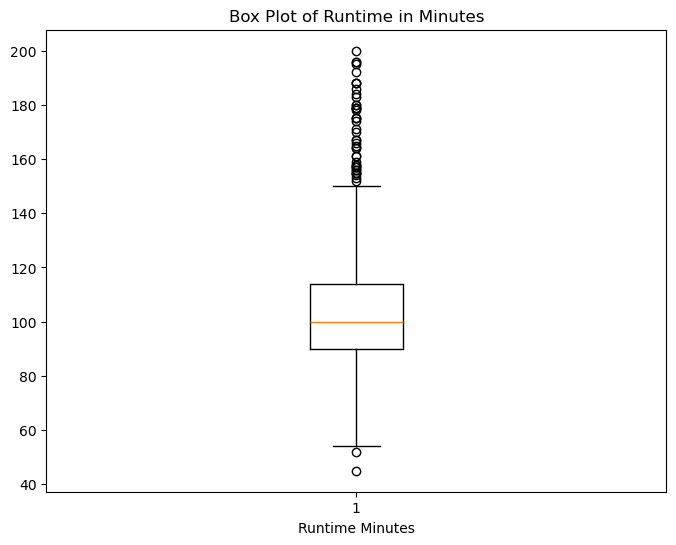

In [19]:
plt.figure(figsize=(8, 6))
plt.boxplot(rtmdf['runtime'])
plt.xlabel('Runtime Minutes')
plt.title('Box Plot of Runtime in Minutes')
plt.show()

## Univariate Analysis

### Histogram plot for top ten directors.

/home/ikn/miniforge3/envs/learn-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


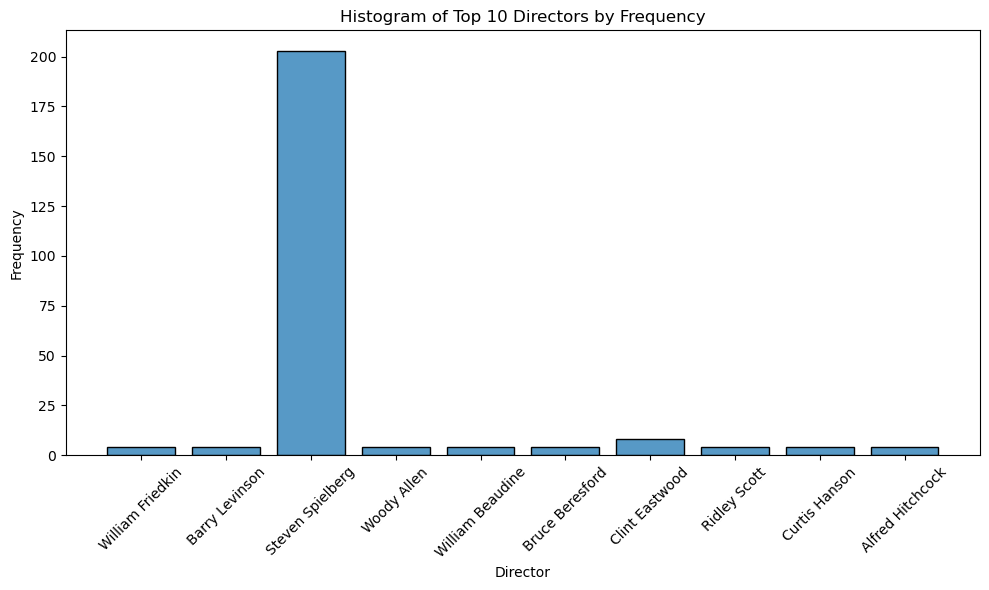

In [20]:
# Get the top 10 directors
top_10_directors = rtmdf['director'].value_counts().head(10).index

# Filter the DataFrame to include only the top 10 directors
top_10_df = rtmdf[rtmdf['director'].isin(top_10_directors)]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=top_10_df, x='director', shrink=.8)
plt.xticks(rotation=45)
plt.xlabel('Director')
plt.ylabel('Frequency')
plt.title('Histogram of Top 10 Directors by Frequency')
plt.tight_layout()
plt.show()

### Histogram plot to determine top writers.

In [ ]:
# Get the top 10 directors
top_10_directors = rtmdf['writer'].value_counts().head(10).index

# Filter the DataFrame to include only the top 10 directors
top_10_df = rtmdf[rtmdf['writer'].isin(top_10_directors)]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=top_10_df, x='writer', shrink=.8)
plt.xticks(rotation=45)
plt.xlabel('Writer')
plt.ylabel('Frequency')
plt.title('Histogram of Top 10 Writer by Frequency')
plt.tight_layout()
plt.show()

### Histogram plot for Runtime 

In [ ]:
runtime_counts = rtmdf['runtime'].value_counts()
top_10_runtime = runtime_counts.head(10).index
data2_top_10_runtime = rtmdf[rtmdf['runtime'].isin(top_10_runtime)]

In [ ]:
runtime_counts = rtmdf['runtime'].value_counts()
top_10_runtime = runtime_counts.head(10).index
data2_top_10_runtime = rtmdf[rtmdf['runtime'].isin(top_10_runtime)]


plt.figure(figsize=(10, 6))
sns.histplot(data=data2_top_10_runtime, x='runtime', shrink=.8)
plt.xticks(rotation=45)
plt.xlabel('runtime per movie')
plt.ylabel('Frequency')
plt.title('Histogram of Movies runtime by Frequency')
plt.tight_layout()
plt.show()

Here 95 minutes on the x axis shouldn't be considered since we filled in the 30 missing values with 95 minutes which was obtained as the mean of the sql runtime database.

### Bivariate Analysis

### Scatter plot of runtime vs rating

In [ ]:

# Convert 'rating' from object to numeric using Label Encoding
le = LabelEncoder()
rtmdf['rating_encoded'] = le.fit_transform(rtmdf['rating'])
rtmdf['rating_encoded']

In [ ]:
# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(rtmdf['runtime'], rtmdf['rating_encoded'], color='blue', alpha=0.5)

# Label the axes
plt.xlabel('Runtime in Minutes')
plt.ylabel('Encoded Rating')

# Set the title
plt.title('Scatter Plot of Runtime vs. Encoded Rating')

# Adjust x-axis ticks to a range from 0 to max runtime value at intervals max divided by 20.
plt.xticks(ticks=range(0, int(rtmdf['runtime'].max()) + 1, int(rtmdf['runtime'].max() / 20)), rotation=45)

# Adjust y-axis ticks, ensuring they match the encoded ratings
plt.yticks(ticks=range(len(le.classes_)), labels=le.classes_)

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Sort the DataFrame by 'runtime' in descending order
data2_sorted = rtmdf.sort_values(by='runtime', ascending=False)

# Get the top 10 rows
top_10_data2 = data2_sorted.head(10)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar('rating_encoded', top_10_data2['runtime'], color='skyblue')

# Adding labels and title
plt.xlabel('Rating Encoding')
plt.ylabel('Runtime (minutes)')
plt.title('Top 10 Runtimes vs Rating Encoding')

# Display the plot
plt.show()

The above scatter plots show the different ratings of movies that each director and writer is involved in with Adrian Lyne  

#### The hypothesis test for runtime in minutes against rating.

Null hypothesis; There is no significant relation between runtime and rating of movies.

Alternate hypothesis; There is a significant relation between runtime and rating of movies.

In [ ]:
import scipy.stats as stats

# Visualize the relationship between runtime and rating
sns.scatterplot(x='runtime', y='rating_encoded', data=rtmdf)
plt.title('Runtime vs Rating')
plt.xlabel('Runtime')
plt.ylabel('Rating')
plt.show()

# Calculate Pearson correlation coefficient
corr, p_value = stats.pearsonr(rtmdf['runtime'], rtmdf['rating_encoded'])
print(f'Pearson Correlation Coefficient: {corr}, p-value: {p_value}')

### Hypothesis test for Genre binary columns and rating.

In [ ]:
#using ANOVA
# Convert genre binary columns to a list of genre columns
genres = rtmdf.columns[rtmdf.columns.str.startswith('genre_')]

# Perform ANOVA test for each genre
for genre in genres:
    grouped = df[df[genre] == 1]['rating_encoded']
    other = df[df[genre] == 0]['rating_encoded']
    
    f_stat, p_value = f_oneway(grouped, other)
    print(f'ANOVA test for {genre}: F-statistic = {f_stat}, p-value = {p_value}')